# Decision Trees

Decision Trees can perform both classification regression tasks, and even multioutput tasks.

They are also the fundamental components of Random Forests.

With Decision trees, we will
* train, visualize and make predictions
* go through the CART training algorithm
* regularize trees and
* discuss its limitations.

## Setup

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Training and Visualizing a Decision Tree

In [52]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()

X = iris.data[:,(2,3)]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

tree_clf.predict([[5, 1.5]])

array([1])

Visualize the trained Decision Tree:

In [58]:
from sklearn.tree import export_graphviz
# from graphviz import Source

export_graphviz(
    tree_clf,
    out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

# Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

ModuleNotFoundError: No module named 'graphviz'

Saving figure decision_tree_decision_boundaries_plot


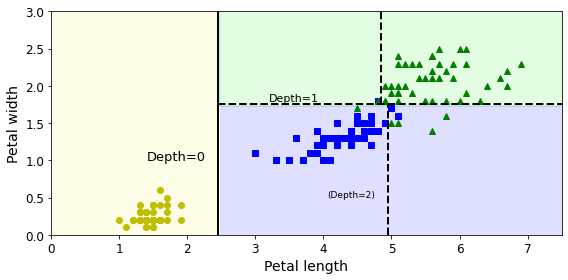

In [54]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], 'k-',  linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], 'k--',  linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], 'k--',  linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], 'k--',  linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=13)
plt.text(3.2, 1.80, "Depth=1", fontsize=11)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=9)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

### Estimating Class Probabilities

In [56]:
# 0/54 - 49/54 - 5/54 => 0% - 90.7% - 9.3%
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [57]:
# predict the class
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm
Scikit-learn used the The *Classification and Regression Tree* (CART) algorithm to train Decision Trees. The algorithm works by splitting the training set into two subsets using a single feature k and a threshold t$_k$ (eg., 'petal length <= 2.45cm').

How does it select t and t$_k$? It searches for the pair (t, t$_k$) that produces the purest subsets. The below equation gives the cost function that the algorithm tries to minimize.

*CART Cost function for classification:*
$$ J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right} $$

where,<br>
&emsp; G$_{left/right}$ measures the impurity of the left/right subset,<br>
&emsp; m$_{left/right}$ is the number of instances in the left/right subset.

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, and so on, recursively.

#### Computational Complexity
Traversing the tree requires going through roughly O(log$_2$(m)) nodes. The training algorithm compares all features(or less if max_features is set) on all samples at each node resulting in training complexity  of **O(n x mlog($_2$(m))**.

#### Gini impurity or Entropy?

Most of the times it does not make a big difference. Gini is slightly faster to compute, so it a good default. 

Giny impurity tends to isolate the most frequent class in its own branch of the tree while, entropy tends to produce slightly more balanced trees.

## Regularization Hyperparameters